In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import StandardScaler
from tkinter import Tk, filedialog


2024-08-05 00:08:19.439363: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Interactive file dialog to choose CSV files
root = Tk()
root.withdraw()  # Hide the root window
csv_file = filedialog.askopenfilename(title="Select the CSV file with historical data")
future_csv_file = filedialog.askopenfilename(title="Select the CSV file with future data")
root.destroy()

# Get user inputs
date_column = input("Enter the name of the date column: ")
feature_columns = input("Enter the names of the feature columns (comma-separated): ").split(',')
target_column = input("Enter the name of the target column to predict: ")


2024-08-05 00:08:25.814 python[28866:1374489] +[CATransaction synchronize] called within transaction
2024-08-05 00:08:26.078 python[28866:1374489] +[CATransaction synchronize] called within transaction
2024-08-05 00:08:36.617 python[28866:1374489] +[CATransaction synchronize] called within transaction
2024-08-05 00:08:36.698 python[28866:1374489] +[CATransaction synchronize] called within transaction


Enter the name of the date column:  Date
Enter the names of the feature columns (comma-separated):  PRB
Enter the name of the target column to predict:  RO.DLTrafficVol ume(GB)


In [5]:
# Load the historical data
df = pd.read_csv(csv_file)
df[date_column] = pd.to_datetime(df[date_column])

# Add seconds
df['Seconds'] = df[date_column].map(pd.Timestamp.timestamp)

df.head()



,Date,Cel I Na me,RO.DLTrafficVol ume(GB),RO.ULTrafficVol ume(GB),RO.Cell Downlink Average Throughput (Mbit/s),RO.Cell Uplink Average Throughput (Mbit/s),RO.User DL Average Throughput (Mbit/s)_M,RO.User UL Average Throughput (Mbit/s)_M,RO.Cell Average User(number),RO.Cell Maximum User(number),Avg CQI,L.UL.Interference.Avg(dBm),DL PRB Usa ge Rate (%),UL PRB Usa ge Rate (%),PRB,Seconds
0,2024-01-26,Cell 1,21.4251,2.0405,24.6750,2.8881,23.4989,2.7962,46,154,10.5001,-116,7.0652,12.7076,100,1.706227e+09
1,2024-01-27,Cell 1,17.2311,1.5501,22.5754,2.6127,21.5843,2.5318,38,107,10.6688,-116,6.6690,11.5938,100,1.706314e+09
2,2024-01-28,Cell 1,18.0000,1.7033,22.9886,2.6468,21.2842,2.5506,36,137,10.6139,-116,6.9319,11.8728,100,1.706400e+09
3,2024-01-29,Cell 1,40.7754,5.2420,22.6365,4.1651,19.9178,3.8707,72,226,11.2420,-116,12.2986,17.6915,100,1.706486e+09
4,2024-01-30,Cell 1,29.5239,3.9349,21.7295,4.1719,19.6052,3.9530,55,187,10.9570,-116,10.8181,15.0149,100,1.706573e+09


In [7]:
#add usable infos about time
day = 60*60*24
year = 365.2425*day

df['Day sin'] = np.sin(df['Seconds'] * (2* np.pi / day))
df['Day cos'] = np.cos(df['Seconds'] * (2 * np.pi / day))
df['Year sin'] = np.sin(df['Seconds'] * (2 * np.pi / year))
df['Year cos'] = np.cos(df['Seconds'] * (2 * np.pi / year))

#drop seconds
df = df.drop('Seconds', axis=1)
df.head()

,Date,Cel I Na me,RO.DLTrafficVol ume(GB),RO.ULTrafficVol ume(GB),RO.Cell Downlink Average Throughput (Mbit/s),RO.Cell Uplink Average Throughput (Mbit/s),RO.User DL Average Throughput (Mbit/s)_M,RO.User UL Average Throughput (Mbit/s)_M,RO.Cell Average User(number),RO.Cell Maximum User(number),Avg CQI,L.UL.Interference.Avg(dBm),DL PRB Usa ge Rate (%),UL PRB Usa ge Rate (%),PRB,Day sin,Day cos,Year sin,Year cos
0,2024-01-26,Cell 1,21.4251,2.0405,24.6750,2.8881,23.4989,2.7962,46,154,10.5001,-116,7.0652,12.7076,100,-8.332735e-12,1.0,0.415448,0.909617
1,2024-01-27,Cell 1,17.2311,1.5501,22.5754,2.6127,21.5843,2.5318,38,107,10.6688,-116,6.6690,11.5938,100,-4.034197e-12,1.0,0.431034,0.902336
2,2024-01-28,Cell 1,18.0000,1.7033,22.9886,2.6468,21.2842,2.5506,36,137,10.6139,-116,6.9319,11.8728,100,2.643420e-13,1.0,0.446492,0.894788
3,2024-01-29,Cell 1,40.7754,5.2420,22.6365,4.1651,19.9178,3.8707,72,226,11.2420,-116,12.2986,17.6915,100,-9.989035e-12,1.0,0.461818,0.886975
4,2024-01-30,Cell 1,29.5239,3.9349,21.7295,4.1719,19.6052,3.9530,55,187,10.9570,-116,10.8181,15.0149,100,-5.690496e-12,1.0,0.477007,0.878899


In [9]:
#update features
feature_columns=[]
feature_columns.extend(['Day sin', 'Day cos', 'Year sin', 'Year cos'])
feature_columns= feature_columns[1:]
feature_columns

['Day cos', 'Year sin', 'Year cos']

In [11]:
# Load the historical data

df = df[[date_column] + feature_columns + [target_column]]
df.head()

,Date,Day cos,Year sin,Year cos,RO.DLTrafficVol ume(GB)
0,2024-01-26,1.0,0.415448,0.909617,21.4251
1,2024-01-27,1.0,0.431034,0.902336,17.2311
2,2024-01-28,1.0,0.446492,0.894788,18.0000
3,2024-01-29,1.0,0.461818,0.886975,40.7754
4,2024-01-30,1.0,0.477007,0.878899,29.5239


In [13]:
# Use the same date range as in the second code
start_date = np.array(df[date_column])[10]
end_date = np.array(df[date_column])[-1]

In [15]:
# Load the future data
df_future = pd.read_csv(future_csv_file)
df_future[date_column] = pd.to_datetime(df_future[date_column])
# Add seconds
df_future['Seconds'] = df_future[date_column].map(pd.Timestamp.timestamp)

df_future.head()

,Date,PRB,Seconds
0,2024-07-23,130,1.721693e+09
1,2024-07-24,130,1.721779e+09
2,2024-07-25,130,1.721866e+09
3,2024-07-26,130,1.721952e+09
4,2024-07-27,130,1.722038e+09


In [17]:



#add usable infos about time
day = 60*60*24
year = 365.2425*day

df_future['Day sin'] = np.sin(df_future['Seconds'] * (2* np.pi / day))
df_future['Day cos'] = np.cos(df_future['Seconds'] * (2 * np.pi / day))
df_future['Year sin'] = np.sin(df_future['Seconds'] * (2 * np.pi / year))
df_future['Year cos'] = np.cos(df_future['Seconds'] * (2 * np.pi / year))
#drop seconds
df_future = df_future.drop('Seconds', axis=1)
df_future.head()

,Date,PRB,Day sin,Day cos,Year sin,Year cos
0,2024-07-23,130,-1.014583e-11,1.0,-0.358014,-0.933716
1,2024-07-24,130,-5.847290e-12,1.0,-0.374022,-0.927420
2,2024-07-25,130,-1.548752e-12,1.0,-0.389920,-0.920849
3,2024-07-26,130,-1.180213e-11,1.0,-0.405703,-0.914005
4,2024-07-27,130,-7.503590e-12,1.0,-0.421366,-0.906891


In [19]:
#
df_future = df_future[[date_column] + [col for col in feature_columns if col != target_column]]
df_future.head()


,Date,Day cos,Year sin,Year cos
0,2024-07-23,1.0,-0.358014,-0.933716
1,2024-07-24,1.0,-0.374022,-0.927420
2,2024-07-25,1.0,-0.389920,-0.920849
3,2024-07-26,1.0,-0.405703,-0.914005
4,2024-07-27,1.0,-0.421366,-0.906891


In [21]:
# Function to convert string to datetime
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

# Set the date column as the index for df
df.set_index(date_column, inplace=True)

# Set the date column as the index for df_future
df_future.set_index(date_column, inplace=True)
df.head()

,Day cos,Year sin,Year cos,RO.DLTrafficVol ume(GB)
Date,,,,
2024-01-26,1.0,0.415448,0.909617,21.4251
2024-01-27,1.0,0.431034,0.902336,17.2311
2024-01-28,1.0,0.446492,0.894788,18.0000
2024-01-29,1.0,0.461818,0.886975,40.7754
2024-01-30,1.0,0.477007,0.878899,29.5239


In [23]:
# Normalize the data
scaler = StandardScaler()
df[feature_columns + [target_column]] = scaler.fit_transform(df[feature_columns + [target_column]])
df_future[[col for col in feature_columns if col != target_column]] = scaler.fit_transform(df_future[[col for col in feature_columns if col != target_column]])
df.head()

,Day cos,Year sin,Year cos,RO.DLTrafficVol ume(GB)
Date,,,,
2024-01-26,0.0,-0.463889,1.763094,-0.301789
2024-01-27,0.0,-0.423721,1.752023,-0.832423
2024-01-28,0.0,-0.383881,1.740545,-0.735140
2024-01-29,0.0,-0.344382,1.728664,2.146454
2024-01-30,0.0,-0.305235,1.716385,0.722889


In [25]:
def df_to_windowed_df(dataframe, first_date, last_date, n=10):
    # Convert dates to pandas Timestamp if they're not already
    first_date = pd.to_datetime(first_date)
    last_date = pd.to_datetime(last_date)
    target_date = first_date
    
    dates = []
    X, Y = [], []
    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)
        
        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            break  # Terminate the loop if the window size is too large
        values = df_subset.to_numpy()
        x, y = values[:-1], values[-1]
        dates.append(target_date)
        X.append(x)
        Y.append(y)
        next_week = dataframe.loc[target_date:target_date + pd.Timedelta(days=7)]
        if len(next_week) < 2:
            break  # If there are no further dates, break the loop
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year, month, day = map(int, next_date_str.split('-'))
        next_date = datetime.datetime(year=year, month=month, day=day)

        if last_time:
            break
        target_date = next_date
        if target_date >= last_date:
            last_time = True
    
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates
    
    X = np.array(X)
    for i in range(0, n):
        for j, col in enumerate(feature_columns + [target_column]):
            ret_df[f'Target-{n-i} {col}'] = X[:, i, j]
    
    Y = np.array(Y)
    for j, colu in enumerate(feature_columns + [target_column]):
        ret_df[f'Target {colu}'] = Y[:, j]
    
    return ret_df

# Usage
windowed_df = df_to_windowed_df(df, start_date, end_date, n=10)
if windowed_df is None or windowed_df.empty:
    raise ValueError("Generated windowed DataFrame is empty. Check the date range and window size.")

In [27]:
# Function to convert windowed DataFrame to X, y
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0]

    middle_matrix = df_as_np[:, 1:-(len(feature_columns)+1)]
    
    X = middle_matrix.reshape((len(dates), 10, len(feature_columns)+1))
    
    Y = df_as_np[:, -(len(feature_columns)+1):]

    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)
df.head()


,Day cos,Year sin,Year cos,RO.DLTrafficVol ume(GB)
Date,,,,
2024-01-26,0.0,-0.463889,1.763094,-0.301789
2024-01-27,0.0,-0.423721,1.752023,-0.832423
2024-01-28,0.0,-0.383881,1.740545,-0.735140
2024-01-29,0.0,-0.344382,1.728664,2.146454
2024-01-30,0.0,-0.305235,1.716385,0.722889


In [29]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]



In [31]:
model = Sequential([
    Input((10, len(feature_columns)+1)),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(len(feature_columns)+1)  # Output target value
])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=32)



Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - loss: 0.5969 - mean_absolute_error: 0.5585 - val_loss: 0.9671 - val_mean_absolute_error: 0.8207
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5207 - mean_absolute_error: 0.5364 - val_loss: 0.9522 - val_mean_absolute_error: 0.8106
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5002 - mean_absolute_error: 0.5243 - val_loss: 0.9407 - val_mean_absolute_error: 0.8026
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5101 - mean_absolute_error: 0.5218 - val_loss: 0.9320 - val_mean_absolute_error: 0.7961
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.5186 - mean_absolute_error: 0.5330 - val_loss: 0.9211 - val_mean_absolute_error: 0.7901
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.4835 - mean_absolute_error: 0.5128 - val_loss: 0.9070 - val_mean_absolute_error: 0.7824
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.4632 - mean_absolute_error: 0.4992 - val_loss: 0.88

In [33]:
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_val)
test_predictions = model.predict(X_test)



5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [35]:
# Prepare to predict future values
last_window = X[-1]  # Use the last window of data for prediction

future_predictions = []
future_dates = []

# Generate future dates
for future_date in df_future.index:
    future_dates.append(future_date)

# Predict future values
for future_date in future_dates:
    future_values = df_future.loc[future_date].to_numpy()
    
    next_prediction = model.predict(np.array([last_window]))
    future_predictions.append(next_prediction.flatten())
    
    # Update the last window with the new prediction and future data
    last_window = np.roll(last_window, -1, axis=0)
    last_window[-1, 1:] = future_values
    last_window[-1, 0] = next_prediction[0][0]

future_predictions = np.array(future_predictions)

future_predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

array([[-0.03115754, -1.0255529 , -1.0774881 , -0.75895566],
       [-0.02575315, -0.956584  , -1.0431571 , -0.87792706],
       [-0.02426437, -0.8796129 , -0.97514814, -0.8971346 ],
       ...,
       [-0.05341559,  0.47303897,  0.94531196,  1.3725301 ],
       [-0.05151048,  0.46905717,  0.9277648 ,  1.3513314 ],
       [-0.04939746,  0.4649393 ,  0.91002196,  1.3296702 ]],
      dtype=float32)

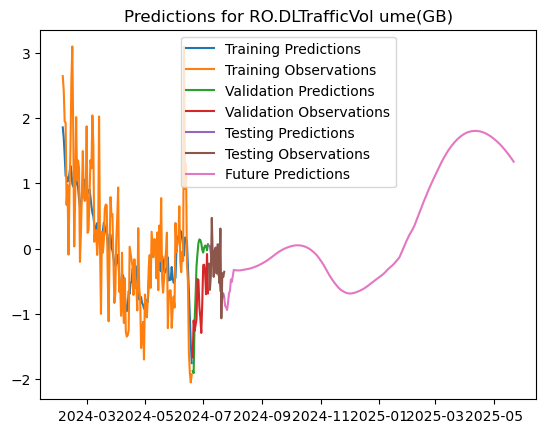

In [37]:
# Allow user to choose the variable to plot
plot_variable = target_column
plt.plot(dates_train, train_predictions[:,-1], label='Training Predictions')
plt.plot(dates_train, y_train[:, -1], label='Training Observations')
plt.plot(dates_val, val_predictions[:, -1], label='Validation Predictions')
plt.plot(dates_val, y_val[:, -1], label='Validation Observations')
plt.plot(dates_test, test_predictions[:, -1], label='Testing Predictions')
plt.plot(dates_test, y_test[:, -1], label='Testing Observations')
plt.plot(future_dates, future_predictions[:, -1], label='Future Predictions')
plt.legend()
plt.title(f'Predictions for {plot_variable}')
plt.show()
